## Note: this is a work in progress
This notebook will demonstrate an implementation of the Heath-Jarrow-Morton interest rate model for pricing derivatives. __[Here is a nice primer on the HJM model](https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote24.pdf)__ as well as a good discussion of Black-Scholes if you want more math.

However, the primer does not discuss in detail how we obtain the volatility for our model in order to implement monte carlo simulation. The answer is that we do Principal Component Analysis (PCA) on historical forward rates. PCA is a process of dimension reduction that allows us to find the variance in historical rates that is not 'noise' and then plug that volatility into HJM equations to run the simulation. In the following cells we will implement PCA on forward rates obtained from the Fed.

First, we will use the pandas datareader package along with the datetime package to import the historical forward rates. We will use five years worth of interest rates. You do want to make sure that your rates are relatively consistent, ie there were no large increases or decreases during the time period or the results won't be accurate. One note: The Fed helpfully provides us with fitted instaneous forward rates (what we need for the equation) but only does so for significant tenors: years 1 through 10. This isn't really enough for a robust model but since this is just for learning purposes we won't consternate about it. To get enough data, you would need to get monthly spot rates and convert to forward rates.

In [19]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import splrep, splev

In [2]:
start = date(2014, 1, 1)
series_code = ['THREEFF1', 'THREEFF2','THREEFF3','THREEFF4','THREEFF5','THREEFF6', 'THREEFF7', 'THREEFF8', 'THREEFF9', 'THREEFF10']
fwdrates = DataReader(series_code, 'fred', start)
fwdrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1499 entries, 2014-01-01 to 2019-09-30
Data columns (total 10 columns):
THREEFF1     1438 non-null float64
THREEFF2     1438 non-null float64
THREEFF3     1438 non-null float64
THREEFF4     1438 non-null float64
THREEFF5     1438 non-null float64
THREEFF6     1438 non-null float64
THREEFF7     1438 non-null float64
THREEFF8     1438 non-null float64
THREEFF9     1438 non-null float64
THREEFF10    1438 non-null float64
dtypes: float64(10)
memory usage: 128.8 KB


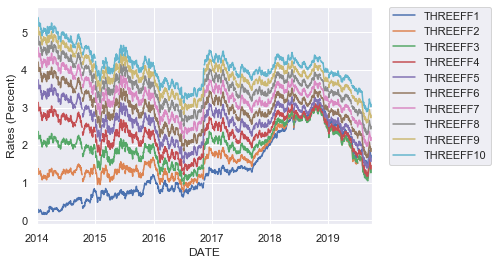

In [3]:
%matplotlib inline
sns.set()
fwdrates.plot()
plt.ylabel('Rates (Percent)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Here we can see the forward rates from one year to 10 years hence on each day going back five years. You can see how they've converged or even overlapped at the bottom end over time.

We need to fix our data by eliminating empty data points, and we also need to change our dataframe into the differences between rates day-to-day rather than the rates themselves. This is because we're modeling how the rates move over time and we're interested in the variance of these movements, not the variance of the individual rates.

In [4]:
fwdrates = fwdrates.diff()
fwdrates = fwdrates.dropna(axis=0)
fwdrates.head()


,THREEFF1,THREEFF2,THREEFF3,THREEFF4,THREEFF5,THREEFF6,THREEFF7,THREEFF8,THREEFF9,THREEFF10
DATE,,,,,,,,,,
2014-01-03,0.0312,0.0257,0.0160,0.0086,0.0038,0.0007,-0.0013,-0.0025,-0.0032,-0.0036
2014-01-06,0.0031,-0.0185,-0.0382,-0.0509,-0.0580,-0.0615,-0.0625,-0.0620,-0.0605,-0.0585
2014-01-07,0.0067,-0.0082,-0.0228,-0.0323,-0.0378,-0.0406,-0.0415,-0.0414,-0.0405,-0.0393
2014-01-08,0.0567,0.0779,0.0841,0.0854,0.0846,0.0825,0.0797,0.0765,0.0731,0.0697
2014-01-09,-0.0019,-0.0182,-0.0326,-0.0417,-0.0468,-0.0490,-0.0496,-0.0490,-0.0478,-0.0461


Our data is clean, let's fix the column names.

In [5]:
columns = ('One Year', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten')
fwdrates.columns = columns

In [6]:
fwdrates.head()

,One Year,Two,Three,Four,Five,Six,Seven,Eight,Nine,Ten
DATE,,,,,,,,,,
2014-01-03,0.0312,0.0257,0.0160,0.0086,0.0038,0.0007,-0.0013,-0.0025,-0.0032,-0.0036
2014-01-06,0.0031,-0.0185,-0.0382,-0.0509,-0.0580,-0.0615,-0.0625,-0.0620,-0.0605,-0.0585
2014-01-07,0.0067,-0.0082,-0.0228,-0.0323,-0.0378,-0.0406,-0.0415,-0.0414,-0.0405,-0.0393
2014-01-08,0.0567,0.0779,0.0841,0.0854,0.0846,0.0825,0.0797,0.0765,0.0731,0.0697
2014-01-09,-0.0019,-0.0182,-0.0326,-0.0417,-0.0468,-0.0490,-0.0496,-0.0490,-0.0478,-0.0461


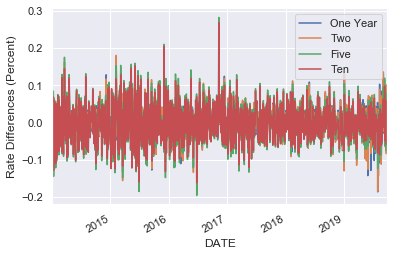

In [7]:
fwdrates[['One Year', 'Two', 'Five', 'Ten']].plot()
plt.ylabel('Rate Differences (Percent)')
plt.show()

Note how taking the differences takes the drift out of it. Again, it's the variance/volatility we are interested in

To perform PCA, we are seeking to reducing the dimensions from 10 to a few. How many exactly? Well we have to do some calculations to find out. Scikit-learn has a PCA function that is very powerful, but for our purposes it can be hard to determine how many components to use. For example:

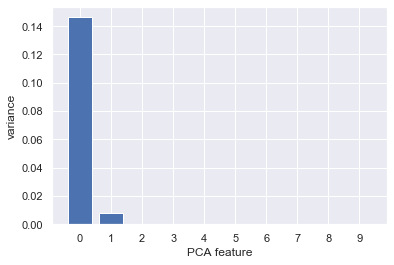

In [8]:
scaled_fwdrates = fwdrates*260/100 #you have to annualize the rates since they are daily, then divide by 100 to convert to decimal
from sklearn.decomposition import PCA
model = PCA()
pca_features = model.fit(scaled_fwdrates)
features = range(pca_features.n_components_)
plt.bar(features, pca_features.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Here we've run PCA on the data and are graphing the explained variance of each component, ie how much each component is contributing to the overall variance. As you can see, the first component explains most of the variance, with the second component adding a little, and the others adding virtually nothing. This would lead us to believe we should use two volatility measures in our model. Let's run PCA the 'old fashioned' way and see if it gives us the same answer.

To find our principal components, we do an eigendecomposition of the covariance matrix of our data. __[This blog post](http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/)__ is an excellent description of how/why this is done. The largest eigenvector of the covariance matrix points in the direction of the largest spread of our data and the largest eigenvalue is the spread in this direction and therefore our largest variance. The second largest will be the second largest variance and so on.

Let's calculate our covariance matrix of the interest rate data and find the eigenvectors and eigenvalues.

In [11]:

fwdvalues = fwdrates.values #this converts the dataframe into a numpy array so that we can use the np.cov function
cov = np.cov(fwdvalues.T) #you must take the transpose of the dataframe or you'll have a covariance matrix of the dates, not the tenors
cov.shape #always make sure it's the correct dimension

(10, 10)

In [12]:
lambdas, vecs = np.linalg.eig(cov)
print(lambdas)

[2.16466373e-02 1.13305728e-03 1.90044702e-06 1.87545971e-09
 1.83010452e-09 1.41747020e-09 1.73543723e-09 1.64081385e-09
 1.54922554e-09 1.56836682e-09]


Numpy helpfully gives us the eigenvalues in ascending order. Notice something interesting: the first eigenvalue is indeed much larger than the others, and the second in between. But the third is also quite a bit larger than the fourth, whereas the fourth through tenth are all about the same size. Maybe then we should use three components instead of two?

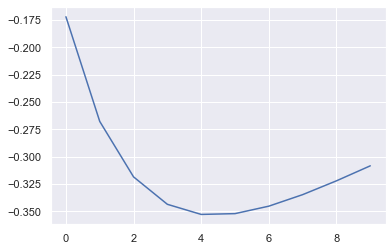

In [13]:
lam1, lam2, lam3 = lambdas[0:3]
PC1= vecs[:, 0]
plt.plot(PC1)


This graph illustrates a problem with using the eig (or eigh) function in numpy: it often returns eigenvectors as the negative of what we want. This is because this eigenvector points in the direction of highest variance, but it could point in either direction. Let's find the largest eigenvector using our own function and see what happens. The following code implements the power method for finding the largest eigenvalue and eigenvector.

In [14]:
def power_method(A):
    tol = 10**(-9)
    iterations = 20000
    eigvec = np.ones(10) #sets out first vector x
    eigvalold = np.dot(np.transpose(eigvec),A.dot(eigvec))/np.dot(np.transpose(eigvec),eigvec)        
    for i in range(iterations):
        eigvec1 = A.dot(eigvec)
        eigvec1norm = np.linalg.norm(eigvec1)
        eigvec = eigvec1 / eigvec1norm #normalizes the vector
        eigval2 = np.dot(np.transpose(eigvec),A.dot(eigvec))/np.dot(np.transpose(eigvec),eigvec)
        if (np.abs(eigval2-eigvalold)/eigval2) < tol:
            return eigval2, eigvec
        eigvalold = eigval2

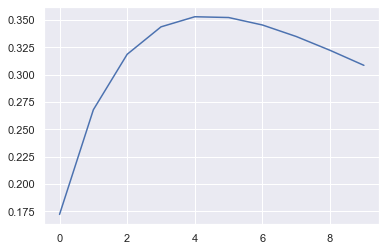

In [15]:
lam1, PC1 = power_method(cov)
plt.plot(PC1)


That's more like it. The first principal component of an interest rate set shows the parallel 'up and down' shifts of the forward rate curve, which we can see even in the first graph mainly explains how they move. We already saw that the first three eigenvalues were larger than the others, let's calculate the explained variance of each. We do this by dividing each eigenvalue by the sum of all the eignvalues.

In [16]:
print('The largest explained variance is {}%'.format(lam1*100/sum(lambdas)))
print('The second largest is {}%'.format(lam2*100/sum(lambdas)))
print('The third largest is {}%'.format(lam3*100/sum(lambdas)))

The largest explained variance is 95.01804520113687%
The second largest is 4.973561782710005%
The third largest is 0.008342023695158317%


So the third one is pretty small. We could leave it out and be fine but let's include it for now and see. Just for fun, let's graph the first six principal components and see what they look like.

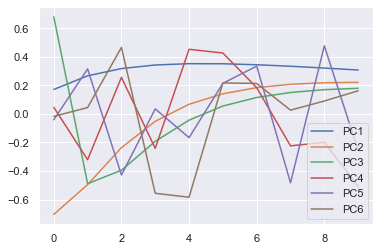

In [17]:
PC2 = vecs[: , 1]
PC3 = vecs[:, 2]
PC4 = vecs[:, 3]
PC5 = vecs[:, 4]
PC6 = vecs[:, 5]
plt.plot(PC1, label = 'PC1')
plt.plot(PC2, label = 'PC2')
plt.plot(PC3, label = 'PC3')
plt.plot(PC4, label = 'PC4')
plt.plot(PC5, label = 'PC5')
plt.plot(PC6, label = 'PC6')
plt.legend()


Notice something interesting: The first three look like they can be attributed to movements in the curve. The first to parallel shifts, the second to a bend and third to a twist. The other ones repeat each other and look like noise. Eliminating this noise is the goal of PCA because we're going to create curves to fit the data. This is why looking at the eigenvalue amounts and graphing the principal components is useful, rather than just graphing the explained variance like we did before.

Next we have to calculate our discretized volatilities. The change in our instantaneous forward rates follows the formula $ ∆f ̅(τ)=±√(λ_1 ) e^((1) ) dX_1±√(λ_2 ) e^((2)) dX_2±√(λ_3 ) e^((3)) dX_3 $

The $ dX $ we will deal with later when we do a monte carlo simulation, but for now we take the square root of our eigenvalues and multiply them by their corresponding eigenvector. This gives both the direction and magnitude of the volatility of our principal components.

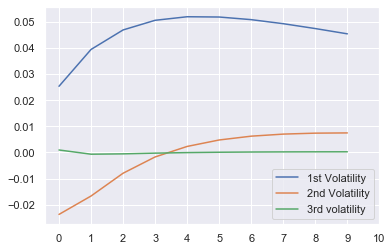

In [18]:
vol1 = np.sqrt(lam1) * PC1
vol2 = np.sqrt(lam2) * PC2
vol3 = np.sqrt(lam3) * PC3
plt.plot(vol1, label='1st Volatility')
plt.plot(vol2, label = '2nd Volatility')
plt.plot(vol3, label = '3rd volatility')
plt.xticks(np.arange(0, 11))
plt.legend()
plt.show()

The third volatility is doing basically nothing so we're not going to use it after all. If we were using a dataset with monthly tenors it's likely we would have at least three principal components / volatilities.

We now need functions to fit these set of points, which will require interpolation. We don't want the fit to be too basic but we also don't want to overfit. It's a similar principle to fitting regression lines (or any statistical model really) except here we're not fitting to a bunch of data points, we're fitting the pattern of the volatility to use in our model. Splines are a good choice, they essentially fit different functions to different parts of the curve. They tend to do better than polynomial regression with non-linear data. 

There are different ways to do spline interpolation, I'm going to use the SciPy library, which has many different interpolation functions. The reason we need to interpolate is because right now we have a set of discrete data points representing our volatilities. We need a function that represents the volatility in order to model our forward curve.

In [27]:
x = np.linspace(0, 10, 10)
spl = splrep(x, vol1)
spl2 = splrep(x, vol2)
x2 = np.linspace(0, 10, 200)
y = splev(x2, spl)
y2 = splev(x2, spl2)

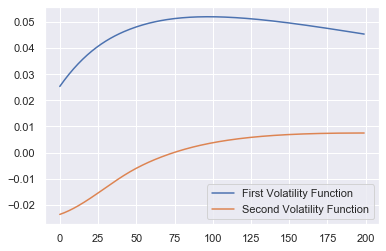

In [33]:
plt.plot(y, label="First Volatility Function")
plt.plot(y2, label="Second Volatility Function")
plt.legend()
plt.show()

How precise we want this interpolation to be depends on how concerned we are with over-fitting. Often the first volatility function is represented by a simple horizontal line, with the second or third getting more precise. Since we're only using two principal components I'm not too worried (and since this is just an academic exercise) I'm not too worried about overfitting.

The next step is to find our drift and then model our forward curves.